## EVALUATING ACCURACY OF PREDETERMINED VARIABLES TO PREDICT SEVERITY OF HEART DISEASE IN PATIENTS

**Adapted by:** Daniel Lee, Eric Leung, & Sam Thorne

**Original Authors:** Emerson Crick, Allie Janowicz, Ziva Subelj, & Sam Thorne

## Introduction

Heart disease refers to a number of different cardiovascular conditions including coronary artery disease, arrhythmia, and heart failure. These diseases have become the leading causes of death in the United States, killing over 659,000 people and costing the government $363 billion each year. Heart disease is associated with a number of factors such as unhealthy blood pressure, cholesterol, and more (National Center for Chronic Disease Prevention and Health Promotion, 2022). 


**We are asking: are age (`age`), maximum heart rate (`max_heart_rate`), and resting blood pressure (`rest_bp`) good at predicting the severity of heart disease in a patient? Based on literature research, we predict that age, maximum heart rate, and resting blood pressure will contribute to the different degrees of heart disease (ranging from 0 being healthy to 4 being the most severe heart cases).**


The data we will use comes from “processed.switzerland.data,” "processed.cleveland.data," "processed.hungarian.data" and "processed.va.data" provided in the Heart Disease dataset (Dua & Graff, 2019). It was collected from the clinical and noninvasive test results of 143 patients undergoing angiography at the University Hospitals in Zurich and Basel, 303 patients undergoing angiography at the Cleveland Clinic in Cleveland, Ohio, 425 patients undergoing angiography at the Hungarian Institute of Cardiology in Bupadepest and 200 patients undergoing angiography at the Veterans Administration Medical Center in Long Beach, California (Detrano et al., 1989). 

Below are the packages we loaded to complete our data analysis:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
library(caret)
library(e1071)
options(repr.matrix.max.rows = 6)
set.seed(1)
source("../R/selection_forward_function.R")
source("../R/majority_classifier_function.R")

# Reading data off internet to make csv files
source("../R/place_data.R")
source("../R/joining_data.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

## Preliminary Exploratory Data Analysis

We combined the datasets “processed.switzerland.data,” "processed.va.data", "processed.cleveland.data," and "processed.hungarian.data", to generate a longer and more complete dataset. Our complete aggregated data contains 13 different columns with an additional 8 that repeat some of the variables as factors instead of numeric types. Based on initial viewing of the data we decided to eliminate the `ST_dep` and `slope` columns as they were missing too many points. 

In [2]:
heart_data <- join_csv()
heart_data

place,age,sex,chest_pain,rest_bp,cholestoral_mmHg,fasting_bs,rest_ECG,max_heart_rate,exercise,⋯,thal,diagnosis,sex_f,chest_pain_f,fasting_bs_f,rest_ECG_f,exercise_f,major_vessels_f,thal_f,diagnosis_f
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
hungary,63,1,4,140,260,0,1,112,1,⋯,NA,2,1,4,0,1,1,NA,NA,2
hungary,44,1,4,130,209,0,1,127,0,⋯,NA,0,1,4,0,1,0,NA,NA,0
hungary,60,1,4,132,218,0,1,140,1,⋯,NA,2,1,4,0,1,1,NA,NA,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
switzerland,72,1,3,160,0,NA,2,114,0,⋯,NA,0,1,3,NA,2,0,2,NA,0
switzerland,73,0,3,160,0,0,1,121,0,⋯,3,1,0,3,0,1,0,NA,3,1
switzerland,74,1,2,145,0,NA,1,123,0,⋯,NA,1,1,2,NA,1,0,NA,NA,1


<span style="color:gray">***Table 1.*** *All columns with all data from the four heart disease data sets.*</style>

## Training and Testing Set

Before creating our classification model, we partition the `heart_data` into a training (75%) and testing (25%) set using the `tidymodels` package. In data analysis it is important to split the data right away to ensure that the classifier we build never sees the testing data. We will train the model using only the training set and test it on the test set once we build the $K$-nn classifier. We will use the variable `diagnosis_f` as our class label as this is what we seek to predict. 

We set the seed with the `set.seed` function in order to make the randomized processes throughout our analysis reproducible. A seed is a numerical starting value, which determines the sequence of random numbers R will generate. Throughout the analysis the `set.seed` function will be at the top of each cell that completes a randomizing action. 

In [3]:
# Splitting data into training and testing sets
set.seed(1)
heart_split<-initial_split(heart_data, prop=0.75, strata=diagnosis_f)
heart_training<-training(heart_split)
heart_testing<-testing(heart_split)

## Literature Research on Predictors

To begin choosing which predictors to use for our classifier, we conducted literature research on columns in our data set to determine their relationship with heart disease. This literature research below helped us to build our initial research question and is later confirmed with the use of foward selection. 

### Resting Blood Pressure

High blood pressure has always been associated with heart attack and heart disease. High blood pressure can damage the arteries by forcing them to stay in a taut position. This decreases the vessels ability to flow blood around the body which can lead to heart disease (Centers for Disease Control and Prevention, n.d.). From this we found indications that higher blood pressure in individuals resulted in coronary heart disease (Gosmanova et al., 2016). According to this research we expect those with higher resting blood pressure to have more severe heart disease. 

### Age

Aging can cause changes in the heart and blood vessels that may increase person's risk of developing cardiovascular disease. Aging to one's heart is asociated with a reduction in its function. Some of the age-associated changes in the heart might be (partially) reversed, by exercise or specific drugs, however, it remains unclear whether this results in any definite advantages for the individual (Roffe, 1998). According to this research we expect older individuals to obtain heart disease of higher severity. 

### Maximum Heart Rate Achieved

A low maximum heart rate can be associated with an increased risk of cardiac disease. Older hearts have a harder time than younger hearts pumping blood throughout the body because the heart gets tired and weaker with age. This can cause a decrease in daily physcial movement because there the heart is not able to preform as it used to. It is suspected that with a lower rate of blood pumping through the heart, there is a greater chance of other factors decreasing heart health that lead to heart disease (Christou & Seals, 2008). According to this research we expect max heart rate will decrease as severity of heart disease increases. 

## Initial Visualizations of Predictors

Warning message:
“Removed 170 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 160 rows containing non-finite values (stat_boxplot).”
Saving 7 x 7 in image



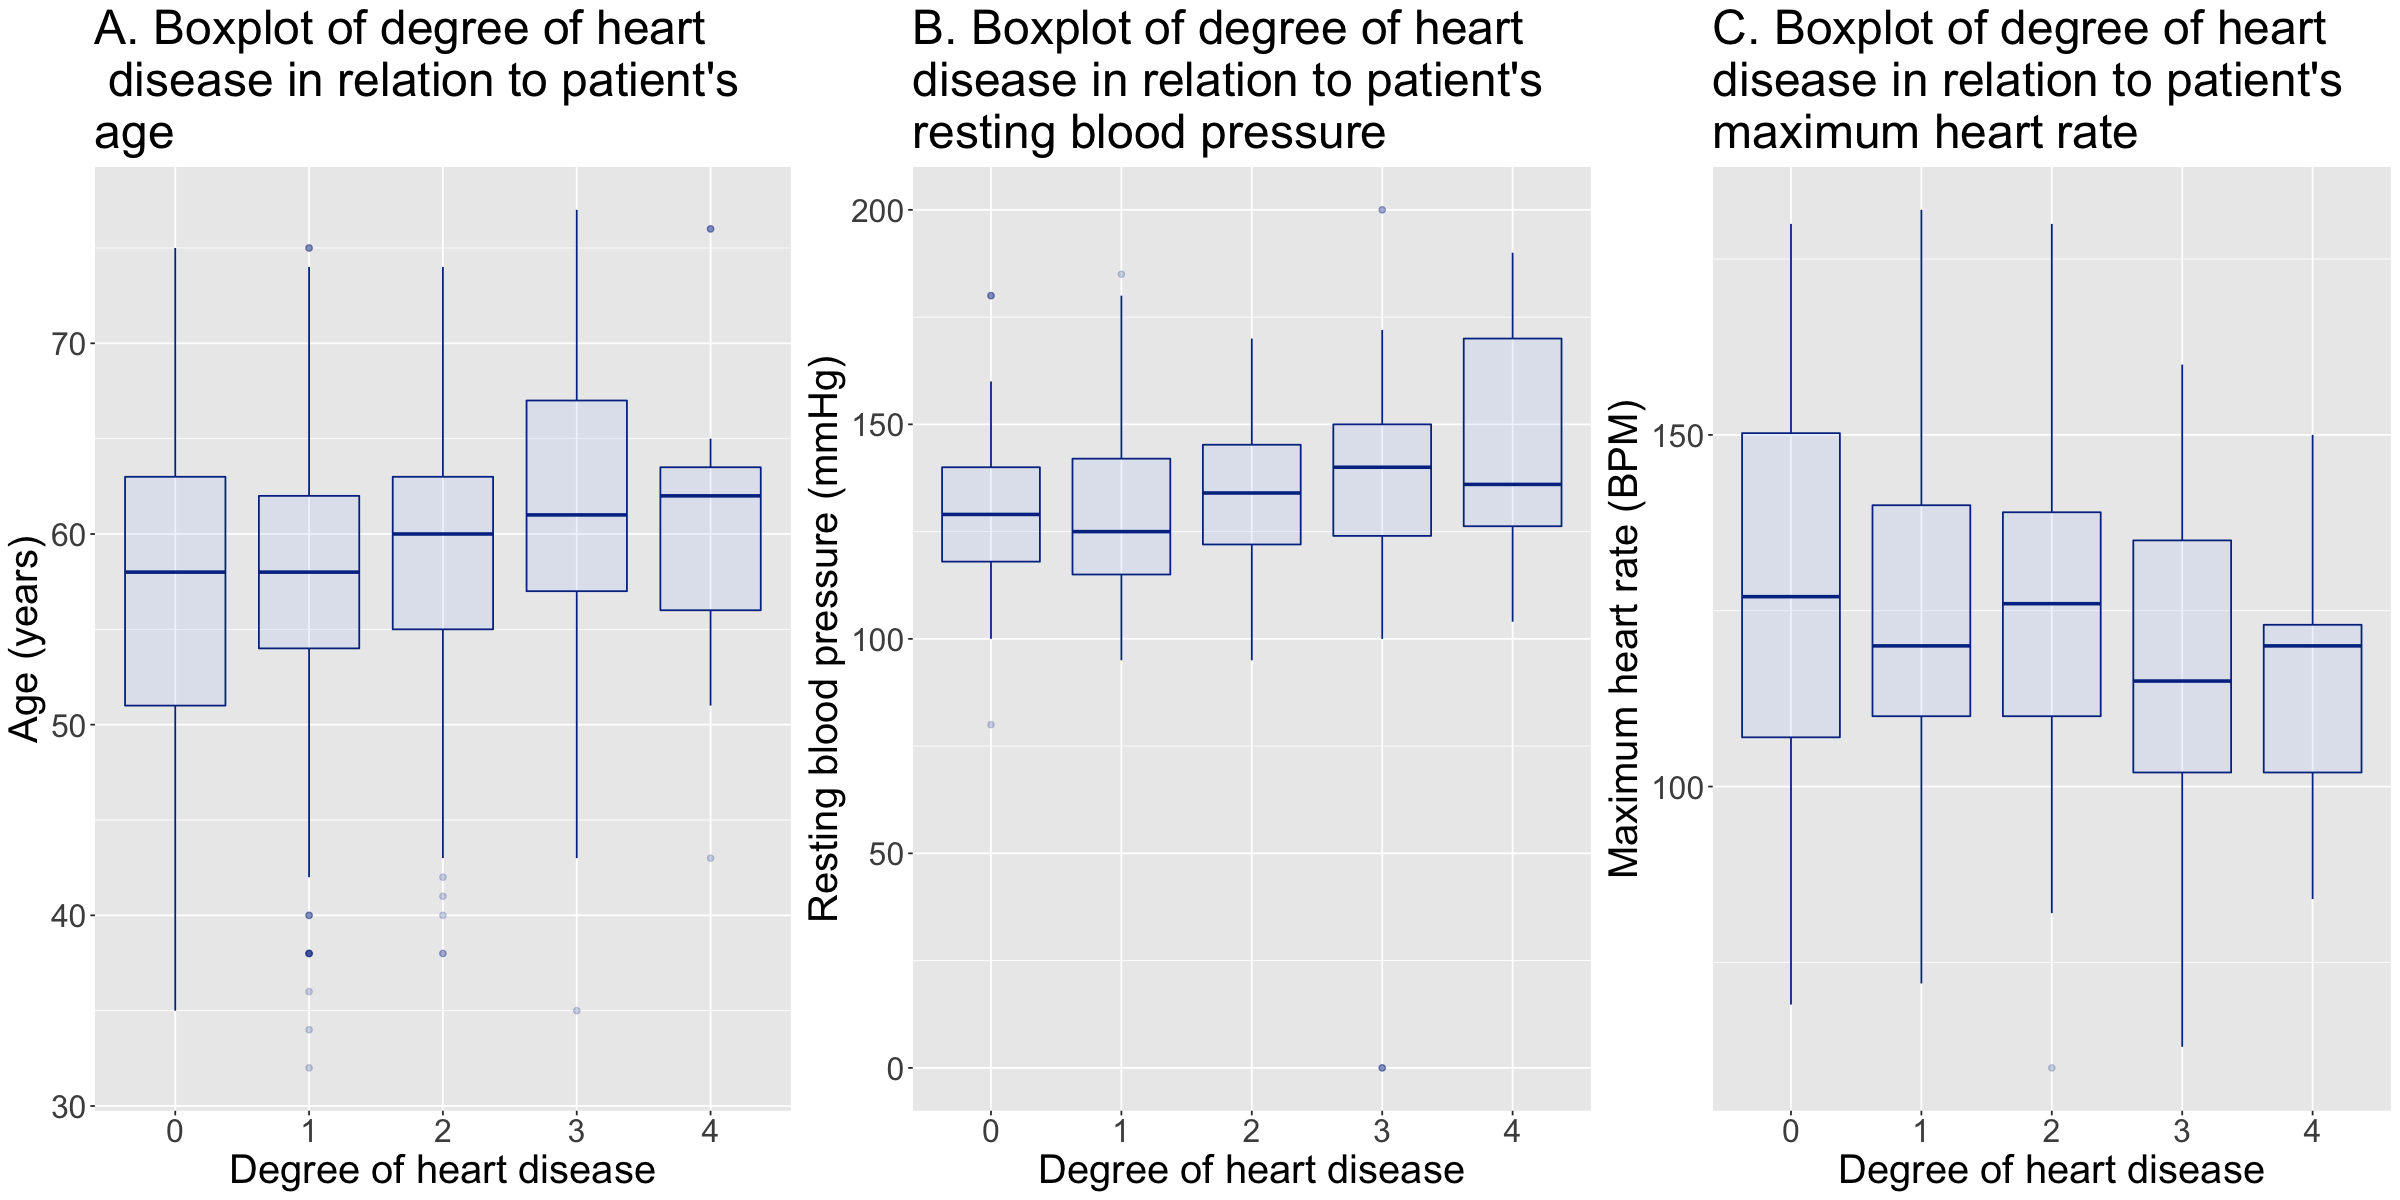

In [4]:
# Boxplot visualizations for each of our predictors and heart diagnosis
source("../R/boxplots.R")

grid_boxplots(heart_data)

<span style="color:gray">***Figure 1.***</style>

These boxplots in Figure 1. are our inital visualizations to see if there really is a correlation between severity of heart disease and our predictors. From looking at all 3 predictors, Figure 1A. `age`, Figure 1B. `rest_bp`, and Figure 1C. `max_heart_rate`, we can see that there is a range of weakly positive and weakly negative to no relationship between the different diagnosed severities of heart disease (`diagnosis_f`)and the predictors.

Figure 1A. shows there is a slight positive relation between age and heart disease severity, meaning the older a patient is, the more severe their heart disease would be.

Figure 1B. shows there is no clear relationship between resting blood pressure and how severe a patients heart disease is. All the medians at different levels of severity are relatively level.

Figure 1C. shows there is a slight negative relationship between maximum heart rate and the severity of heart disease. This means a patient with no heart disease (0) or low severity (1) are able to acheive a higher maximum heart rate. This is because their heart is more healthy and able to pump blood efficiently when compared to a patient with high severity (4) heart disease.

These visualizations are taken into consideration when making our classification model. We will see if these predictors used together will in fact give an accurate diagnosis for someone being examined for heart disease based on given dataset. We chose to proceed with these predictors because of our literature reseach support. In practice, these predictors are conditions that doctors use to give an **initial diagnosis** of heart disease. Our research question as to whether these predictors work to accurately predict the severity is analysed in the remainder of the project report.

## Forward Selection

To visualize the effectiveness of our chosen predictors on our data set, we used the process of forward selection. We chose to add this step to confirm that the choices of our predictors will work using this data, as Figure 1. failed to show any significant correlation.

Forward selection is used to predict accuracy of a classifier that will be made using different predictors to create the model. Based on our literature research detailed above, we will be using forward selection on the variables age, resting blood pressure, and maximum heart rate. We made sure to use our training data set in the forward selection process so that the testing data is never seen by the classifier.

Additionally we chose to run forward selection on chest pain type (`chest_pain`) and sex (`sex`) to get an idea of what our classifier would look like using more variables. 

In [5]:
# Creating data subsets for forward selection model using training data
heart_data_subset<-heart_training%>%
    select(diagnosis_f, age, rest_bp, max_heart_rate, chest_pain, sex) %>%
    na.omit()

# heart_data_subset
write_csv(heart_data_subset, '../data/modelling/forward_selection_subset.csv')

Now that we have a subset of our data to work with, we can run forward selection to produce a table of accuracies based on the number of predictors. This forward selection coding immitates the model that will be made further down in the report. A seed is set to ensure reproducible results. 

Due to the iterative nature of forward selection and the usage of 5 predictors this cell will take a while to run. 

In [6]:
accuracies <- forwardSelection(heart_data_subset)
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,diagnosis_f ~ max_heart_rate,0.4462406
2,diagnosis_f ~ max_heart_rate+rest_bp,0.7610736
3,diagnosis_f ~ max_heart_rate+rest_bp+chest_pain,0.7658033
4,diagnosis_f ~ max_heart_rate+rest_bp+chest_pain+sex,0.7680744
5,diagnosis_f ~ max_heart_rate+rest_bp+chest_pain+sex+age,0.7611596


<span style="color:gray">***Table 2.*** *Forward selection results*</style>

From Table 2. above, we can see that the accuracy increases with every added predictor. To make this result more clear, a visualization of accuracy compared to the number of predictors is included below.

ERROR: [1m[33mError[39m in `plot_dev()`:[22m
[33m![39m Unknown graphics device ''


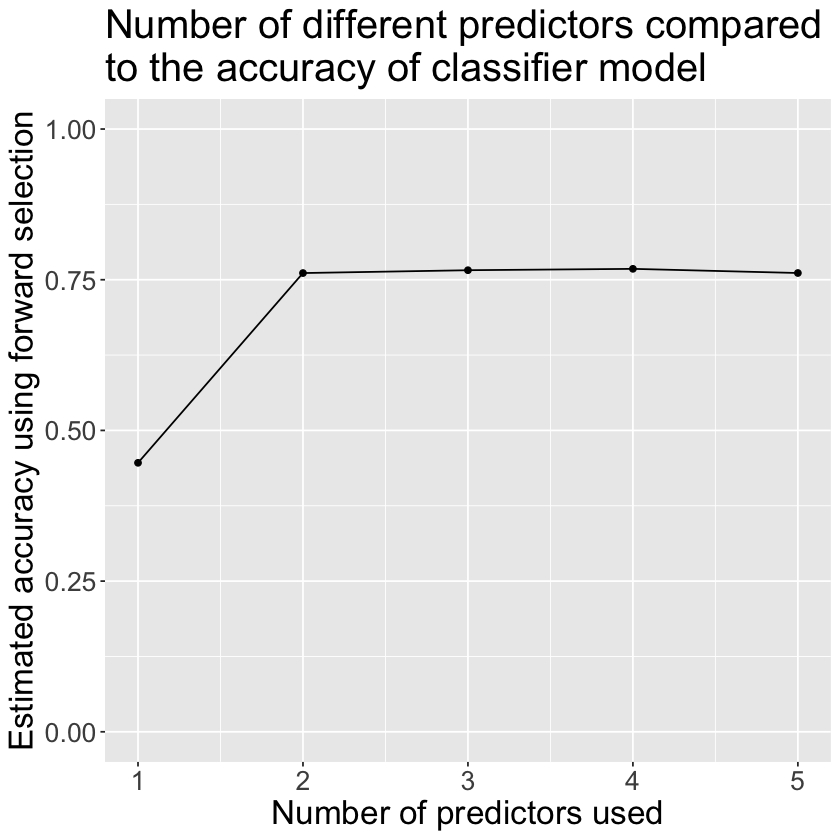

In [11]:
# visualization of number of predictors and accuracy based on forward selection
options(repr.plot.width = 7, repr.plot.height = 7)
forward_visualization <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    geom_point() +
    labs(x = 'Number of predictors used',
         y = 'Estimated accuracy using forward selection',
         title = 'Number of different predictors compared \nto the accuracy of classifier model') +
    theme(text = element_text(size = 20)) +
    ylim(c(0,1))

forward_visualization

<span style="color:gray">***Figure 2.***</style>

Figure 2. shows us that all five of our predictors increase the estimated accuracy of our classifier. However we can also see that the accuracy plateau's at the fourth and fifth predictor (`chest_pain` and `sex`). 

According to this visualization our pre-chosen predictors should be accurate predictors for the severity of heart disease. It also tells us that with any more predictors our classifier would not be benefitted and with any less we would have drastically lower accuracy. 

To conclude, we chose resting blood pressure, age and maximum heart rate as our predictors for the severity of heart disease as seen in row 3 of Table 2. 

### Completing Data tidying

Now that our indicators `age`, `max_heart_rate` and `rest_bp` to predict `diagnosis_f` have been chosen, we can further tidy our data by eliminating the unused columns. Additionally, all the rows containing NA were removed. Since our data has already been split into training and testing sets we will tidy both of the subsets.

In [15]:
# Selecting chosen predictors within training and testing data
heart_training <- heart_training %>%
    select(rest_bp, age, max_heart_rate, diagnosis_f) %>%
    na.omit()
heart_training

# Adding training set to directory
write_csv(heart_training, '../data/modelling/training-split.csv')

heart_testing <- heart_testing %>%
    select(rest_bp, age, max_heart_rate, diagnosis_f) %>%
    na.omit()

# Adding testing set to directory
write_csv(heart_testing, '../data/modelling/testing-data.csv')

rest_bp,age,max_heart_rate,diagnosis_f
<dbl>,<dbl>,<dbl>,<fct>
130,44,127,0
110,66,99,0
170,63,84,4
⋮,⋮,⋮,⋮
145,65,67,3
160,65,122,3
140,70,157,3


<span style="color:gray">***Table 3.*** *Tidied data set containing our selected predictors we will use to determine the severity of heart disease in an individual*</style>

## Majority Classifier

After selecting our predictors we examined the distribution of our outcome variable. Below, we show the majority classifier data frame which displays the proportion of each outcome found in our training data as well as a visualization to accompany it.

In [16]:
# majority classifier and visualization
set.seed(1)
total_rows<-nrow(heart_training)

number_of_columns<-heart_training%>%
    group_by(diagnosis_f)%>%
    summarize(number=n())%>%
    select(number)
    

majority_classifier<-heart_training%>%
    group_by(diagnosis_f)%>%   
    summarize(percent_outcomes=n()/total_rows*100)%>%
     arrange(desc(percent_outcomes))%>%
     bind_cols(number_of_columns)
#slice(1)
majority_classifier

# write csv to data/modelling
write_csv(majority_classifier, '../data/modelling/majority_classifier.csv')

diagnosis_f,percent_outcomes,number
<fct>,<dbl>,<int>
1,31.159420,78
2,22.946860,129
3,21.497585,95
0,18.840580,89
4,5.555556,23


<span style="color:gray">***Table 4.*** *Majority classifier showing the number of people with each severity level of heart disease in the training set*</style>

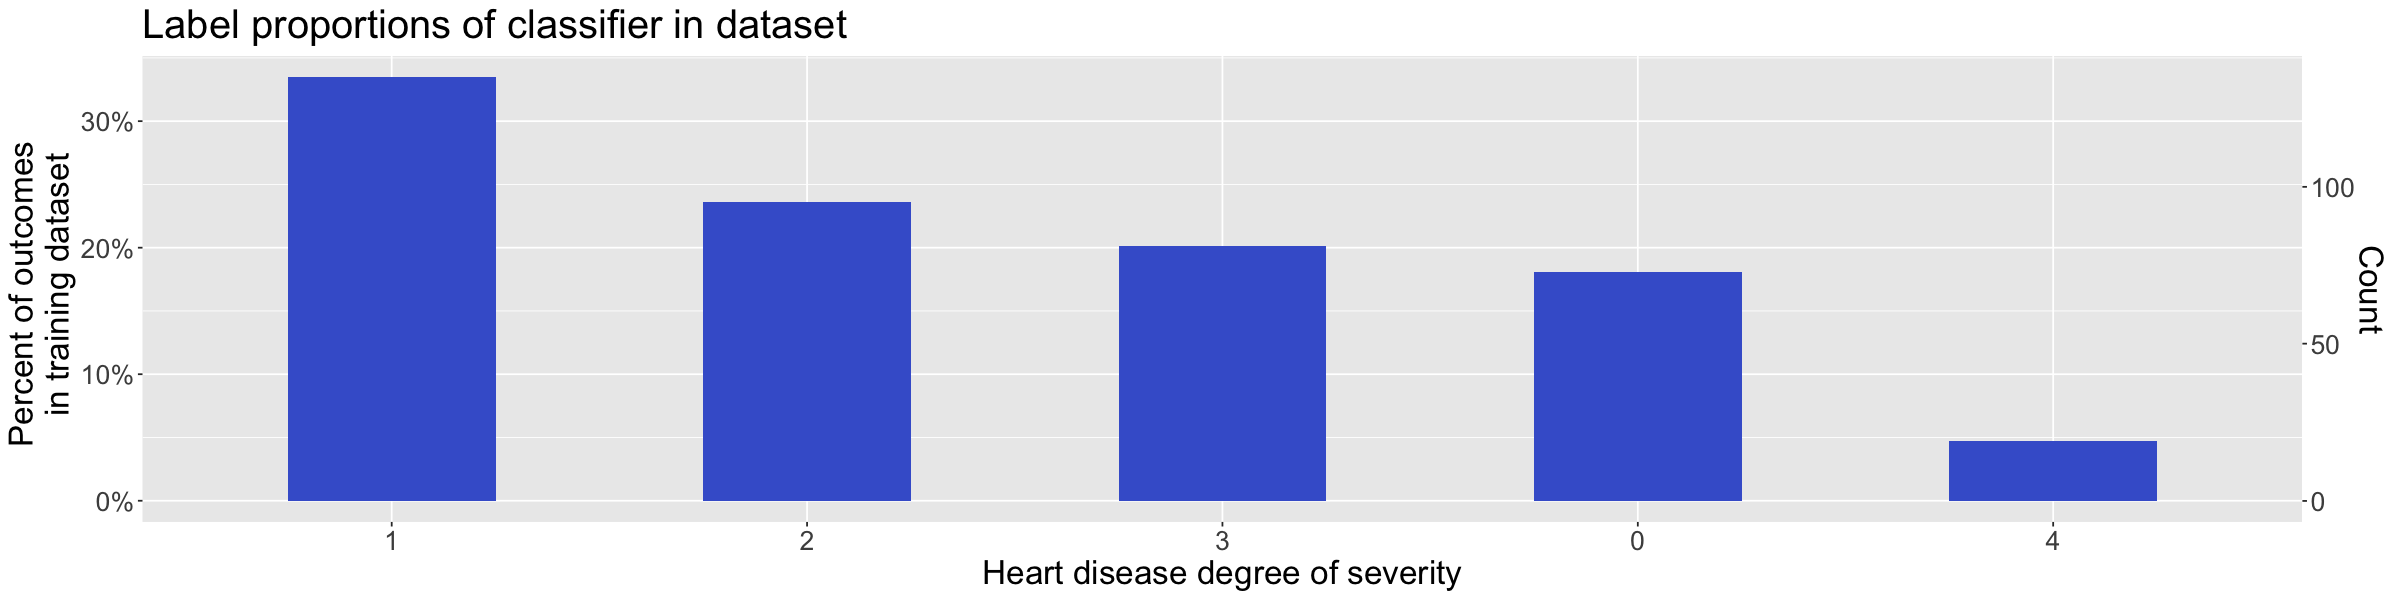

In [12]:
majority_classifier_vis_function(majority_classifier)

<span style="color:gray">***Figure 3.***</style>

Table 4. and Figure 3. give insight into the proportion of patients from the training set with each level of heart disease. The most common diagnosis in our data set is severity 1 with 31%. This value sets a baseline accuracy that our model should exceed to be deemed an acceptable classifier. In other words, if our model can predict more accurately than simply picking the most likely outcome every time, then we are on the right track in terms of accuracy.

Table 4. also shows us that none of the percent outcomes are over 50%, and the outcomes for severity 1, 2, 3, and 0 are within 15% of each other. This means our data set is distributed evenly enough to build a decent classifier model. Knowing the frequency of each outcome also enables us to set an upper bound on our number of neighbors which is something we will discuss in further detail in subsequent cells.

## Classification Model

Because $K$-nearest neighbors is sensitive to the scale of the predictors, we will do some preprocessing to standardize them. We use only our training data to create a recipe for our classifier. This recipe will compute the shift / scale values for each variable, of the data we input into our classifier. For now we will use our training data as this is part of training procedure and we want to ensure that our test data does not influence any aspect of model training.

In [13]:
# Creating recipe for classifier
set.seed(1)
heart_data_recipe<-recipe(diagnosis_f ~ ., data=heart_training)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

Now we will make a model for our classifier being sure to use only the training dataset. 
First we use `tune()`, so that we can find the optimal $K$ (number of neighbors) for our classifier. With `weight_func` we specify that want to use the *straight-line* distance as our measurement between the predictor and our new point. Finally, we must specify that we are conducting classification.

In [14]:
# Creating model for our classifier
set.seed(1)
heart_data_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())%>%
                set_engine("kknn")%>%
                set_mode("classification")

In order to find the optimal $K$ value for our classifier we must now separate our training data into many pieces to test each $K$ we are looking at. Five fold cross validation is used to split the training data into 5 sets of data which is then split into 5 pieces. In each group one of the 5 pieces immitates a testing set and is used to test each $K$ value and determine different accuracies for each $K$. 

We stratified the data by `diagnosis_f` to make sure the new splits contain similar proportions of each of the 5 diagnosis we are trying to predict.

In [15]:
# Splitting our training data to find optimal K value
set.seed(1)
heart_data_vfold<-vfold_cv(heart_training, v=5, strata=diagnosis_f)

We will now run a `workflow()` to determine various accuracies found using different $K$ values. This workflow does the cross-validation work that was described above using our now split training data. This workflow will include our model and recipe that were formed above. We tested $K$ values from one to twenty-one because this is the lowest frequency of diagnoses (category 4 appeared 21 times in the training set). If we were to use a number of neighbors greater than twenty-one the majority voting used in $Knn$ classification would be skewed against diagnosis 4. 

In [16]:
# Cross validation to find optimal K value
set.seed(1)
#change the grid value to gridvals variable
gridvals<-tibble(neighbors = seq(from=1, to=21))

heart_data_results<-workflow()%>%
    add_recipe(heart_data_recipe)%>%
    add_model(heart_data_spec)%>%
    tune_grid(resamples=heart_data_vfold, grid= gridvals)%>%
    collect_metrics()
# heart_data_results

heart_data_accuracies<-heart_data_results%>%
    filter(.metric=="accuracy")
heart_data_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7693694,5,0.01747072,Preprocessor1_Model01
2,accuracy,multiclass,0.7693694,5,0.01747072,Preprocessor1_Model02
3,accuracy,multiclass,0.6029214,5,0.02199167,Preprocessor1_Model03
4,accuracy,multiclass,0.5359949,5,0.01087504,Preprocessor1_Model04
5,accuracy,multiclass,0.4764758,5,0.01283134,Preprocessor1_Model05
6,accuracy,multiclass,0.4737295,5,0.01940515,Preprocessor1_Model06
7,accuracy,multiclass,0.4463785,5,0.01912281,Preprocessor1_Model07
8,accuracy,multiclass,0.4266811,5,0.02341729,Preprocessor1_Model08
9,accuracy,multiclass,0.3945176,5,0.01134555,Preprocessor1_Model09


<span style="color:gray">***Table 5.*** *Parameter values that help select a k value*</style>

To make this table easier to understand, we made a visualization of the mean column and the number of neighbours. The mean represents an accuracy estimate of the model when different $K$ values are used. The optimal $K$ value has the highest accuracy and has neighbouring $K$ values of similar accuracy.

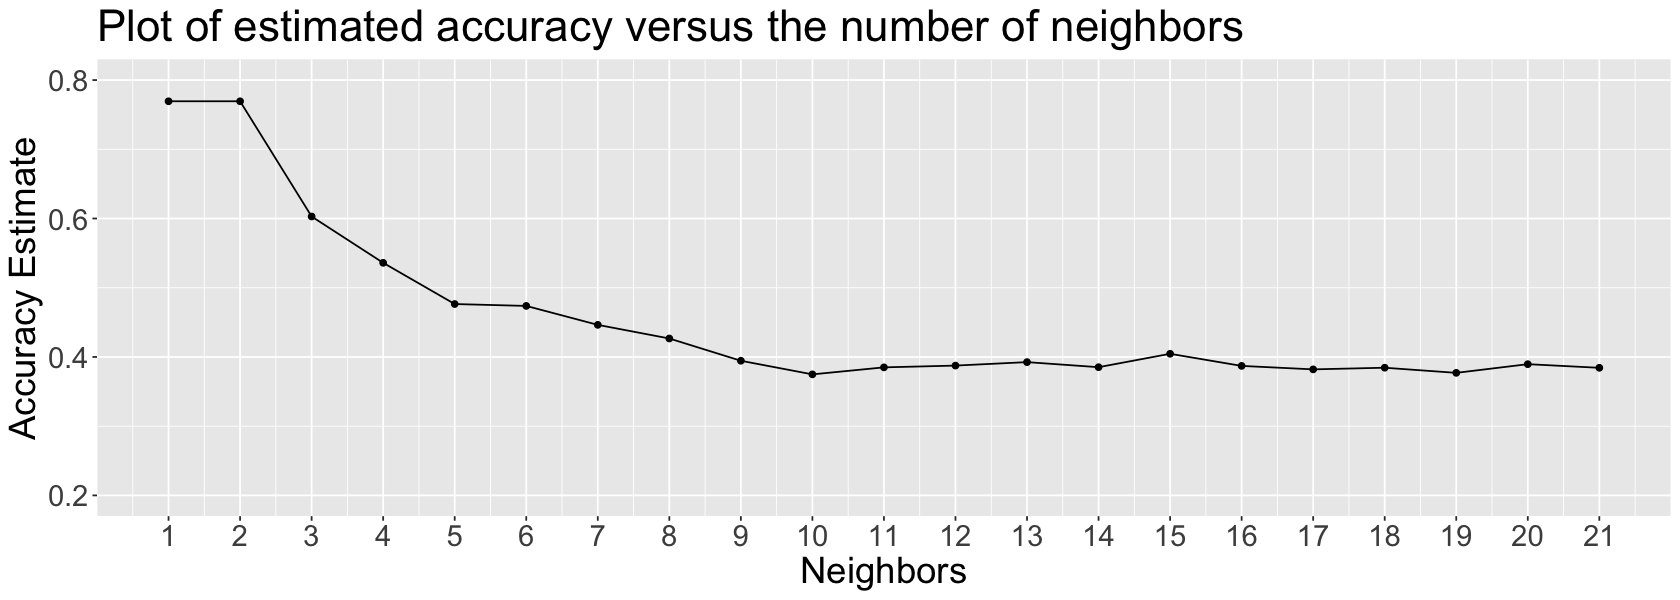

In [17]:
# K visualization
options(repr.plot.width = 14, repr.plot.height = 5)
accuracy_versus_k <- ggplot(heart_data_accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Plot of estimated accuracy versus the number of neighbors") +
        theme(text = element_text(size = 22)) +
        ylim(0.2, 0.8) +
        scale_x_continuous(breaks = 1:21)
accuracy_versus_k

<span style="color:gray">***Figure 4.***</style>

Setting the number of neighbours to $K$ = 2 will give the highest accuracy, as seen in Figure 4. The shape of Figure 4. is not what we expected to see because of the huge drop in the accuracy after $K$ = 2. This means that there is a high risk of losing model accuracy after $K$ = 2. Choosing $K$ = 1 would also work considering the accuracy; however, it is a small number and it could lead to overfitting our classifier.

Figure 4. shows that choosing a $K$ higher than two results in a drastically lower estimated accuracy. We experimented with testing the accuracy of models with higher $K$ values, but they decreased the accuracy even further. For example, when we used three neighbours instead of two, the accuracy decreased by about 15%, and it continued to decrease the higher the $K$ value we used. We also checked for spikes at much higher K values, but the accuracy continued to level off around 0.40. To make this table easier to understand, we made a visualization of the mean column and the number of neighbours. The mean represents an accuracy estimate of the model when different $K$ values are used. The optimal $K$ value has the highest accuracy and has neighbouring $K$ values of similar accuracy.

After our initial analysis in Figure 4. we decided to continue our analysis despite the suspicious shape of Figure 4. This next step pulls optimal the $K$ value based on the above cross validation to choose the appropriate number of neighbors.

In [18]:
# Pulling optimal K value based on above cross validation
set.seed(1)
best_k<-heart_data_accuracies%>%
    arrange(desc(mean))%>%
    slice(2)%>%
    pull(neighbors)
# best_k

Now that we have our optimal $K$ value we continued to build our classifier and started by building a new model using `best_k`. 

In [19]:
# New classifier model using optimal K values
set.seed(1)
heart_data_spec_final<- nearest_neighbor(weight_func="rectangular", neighbors=best_k)%>%
    set_engine("kknn")%>%
    set_mode("classification")

To finalize the classifier we now plug the recipe and model into a workflow so it can be used on other data in the future. This step fits the classifier to our training data therefore enabling it's predictive ability. 

In [20]:
# Final workflow for classifier using new model.
set.seed(1)
heart_data_final_fit<-workflow()%>%
    add_recipe(heart_data_recipe)%>%
    add_model(heart_data_spec_final)%>%
    fit(data=heart_training)
    
#heart_data_final_fit

## Testing the Model

We pass the test set to our workflow to test the accuracy of the model. 

In [21]:
# Testing our classifier using the testing set
set.seed(1)
heart_data_summary<-heart_data_final_fit%>%
    predict(heart_testing)%>%
    bind_cols(heart_testing)%>%
    metrics(truth=diagnosis_f, estimate=.pred_class)%>%
    filter(.metric == 'accuracy')
heart_data_summary

heart_data_predict <- heart_data_final_fit %>%
    predict(heart_testing) %>%
    bind_cols(heart_testing)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7482993


<span style="color:gray">***Table 6.*** *Model accuracy with testing set*</style>

The accuracy is a reasonable number that shows that even though our predictors within our model produce a strange $K$-nearest neighbour graph, we still built a model that will diagnose patients with ~80% accuracy.

We know this is a reasonable accuracy for our classifier from looking at Figure 3. As discussed in the preceding paragraph, we are looking for a classifier with higher accuracy than that of the majority classifier. In our case, the majority label made up ~30% of our dataset, so the accuracy of ~80% is more than double that of our majority label. Therefore, our classifier is reasonably good. 

To test the accuracy of the model we built, we also provide a confusion matrix; a table of predicted and correct labels,  using the `conf_mat` function. This enables us to easily see false positives and false negatives of diagnosis, as well as what was predicted accurately.

In [22]:
# Confusion matrix code
set.seed(1)
confusion_matrix<-heart_data_predict%>%
                    conf_mat(truth=diagnosis_f, estimate=.pred_class)
confusion_matrix
# tibble(confusion)

          Truth
Prediction  0  1  2  3  4
         0 22  3  1  1  0
         1  4 30  6  1  0
         2  4  7 27  4  0
         3  0  2  1 24  0
         4  1  0  1  1  7

<span style="color:gray">***Table 7.*** *Confusion matrix*</style>

A heatmap based on the confusion matrix was made to more easily understand what is being displayed above.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



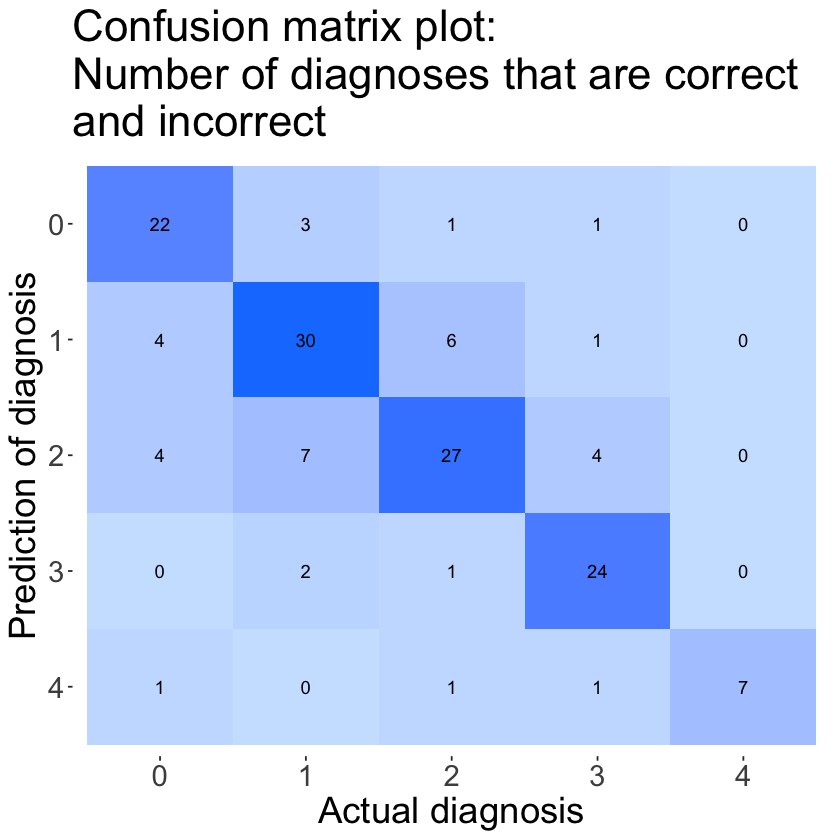

In [23]:
# confusion matrix heat map visualization
options(repr.plot.height = 7, repr.plot.width = 7)
confusion_vis <- autoplot(confusion_matrix, type = "heatmap") +
    theme(text = element_text(size = 22)) +
    labs(y = 'Prediction of diagnosis',
         x = 'Actual diagnosis',
         title = 'Confusion matrix plot: \nNumber of diagnoses that are correct \nand incorrect') +
    scale_fill_gradient(low = '#cce3ff', high = '#177fff')
    
confusion_vis

<span style="color:gray">***Figure 5.***</style>

The confusion matrix (Figure 5.) shows that 22 individuals were correctly diagnosed with no presence of heart disease, 39 were correctly diagnosed with low severity of heart disease, 22 were correctly diagnosed with medium severity of heart disease, 20 were correctly diagnosed with high severity of heart disease, and 4 were correctly diagnosed with extreme severity of heart disease. Therefore, the classifier labeled $22 + 39 + 21 + 20 + 4 = 106$ diagnoses correctly. This is a rather good result as the proportions of each heart disease class diagnosed correctly mirror the proportions seen in the dataset. Our classifier is therefore not favouring one diagnosis over the other.

Unfortunately, the classifier also made errors and classified a total of 18 patients with a false positive, meaning the patient's heart disease was worse than it actually was. Moreover, the classifier labelled six patients with false negatives, meaning the patients' heart disease was actually worse than what was predicted. A discussion as to the false positive and false negative results is in the discussion section.

## Discussion

**Conclusion**

The predictors, `age`, `max_heart_rate`, and `rest_bp`, have high accuracy and a good chance of accurately predicting a patient's heart disease severity. However, some results indicate that these predictors may not be the best in actual practice. For instance, Figure 1. shows that these predictors do not have significant correlations with a diagnosis of severity of heart disease. Additionally, there was a significant drop-off after two neighbours in our $K$ graph, proposing that our accuracy results could be due to luck. However, our confusion matrix reveals promising results.

**Is this what you expected to find?**

We expected to find that the larger the numerical value of a patient's age and resting blood pressure and the lower the maximum heart rate, the greater at risk a person is to have worsened heart disease. We actually found that these predictors have a weak correlation with the outcome variable. However, our model still predicts heart disease severity accurately.

From our confusion matrix in Figure 5., we were more likely to predict a false positive than a false negative. This is good because, with a health condition like heart disease that generates ranging severity, it is better to be given a false positive and be treated as if the disease were worse than be given a false negative and not be treated at all or to a lower care level than what is needed. A reason we see 18 false positives could be because of the predictors we chose to use in our model. We saw in Figure 1. that these predictors are not ideal because of the weak relationships they show with the severities of heart disease. This can also be said as to why we have 6 false negatives. However, considering that the accuracy of our model is good, this is a reasonable number of false negatives. These values for the false positives and false negatives also relate to our research question and conclusion that our selected predictors are primarily good at predicting the preliminary severity of a patient's heart disease. However, a diagnosis cannot be concluded off these factors alone. Unfortunately, false negatives and false positives are given in medicine in the real world, but from actual research and examples like we were able to display in our classification, it is more likely that a patient will have a proper diagnosis than a false positive or negative.

**What impact could such findings have?**

This could give medical professionals an idea that these predictors are good initial tests to check the severity of someone's heart disease, but further testing should be done to have a more accurate diagnosis. The severity levels of heart disease (0 to 4) are hard to distinguish between for our selected predictors, but they can be good indicators of a person having heart disease. This information can also be given to Government health care facilities as a precaution to provide public awareness and send letters to older citizens to check with a doctor on the status of their heart health. Also, individuals who feel they want to watch their heart health can compare their resting blood pressure, age and maximum heart rate with this model to estimate if they have heart disease and to what severity.

**What future Questions could this lead to?**

What further research needs to be done on the predictors (maximum heart rate, age and resting blood pressure) to see if they are actually good predictors of heart disease? How could heart disease be lessened in the future, or how can heart disease be prevented? Patients at what age and with what symptoms should be encouraged to take precautions and see a doctor?

## References

Centers for Disease Control and Prevention. (n.d.) *About High Blood Pressure*. Retrieved March 27, 2022, from https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina

Christou, D. D., &amp; Seals, D. R. (2008). Decreased maximal heart rate with aging is related to reduced β-adrenergic responsiveness but is largely explained by a reduction in intrinsic heart rate. Journal of Applied Physiology, 105(1), 24–29. https://doi.org/10.1152/japplphysiol.90401.2008 

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American Journal of Cardiology, 64*(5), 304-310. https://doi.org/10.1016/0002-9149(89)90524-9

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. Heart Disease Data Set created by William Steinbrunn, M.D. from University Hospital, Zurich, Switzerland, Matthias Pfisterer, M.D. from University Hospital, Basel, Switzerland, Andras Janosi, M.D. from Hungarian Institute of Cardiology, Budapest, Hungary and Robert Detrano, M.D., Ph.D. from V.A. Medical Center, Long Beach and Cleveland Clinic Foundation.

Gosmanova, E. O., Mikkelsen, M. K., Molnar, M. Z., Lu, J. L., Yessayan, L. T., Kalantar-Zadeh, K. & Kovesdy, C. P. (2016). Association of systolic blood pressure variability with mortality, coronary heart disease, stroke, and renal disease. *Journal of the American College of Cardiology, 68*(13), 1375-1097. https://doi.org/10.1016/j.jacc.2016.06.054.

Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved March 10, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

National Center for Chronic Disease Prevention and Health Promotion, Division for Heart Disease and Stroke Prevention. (2022, February 7). *Heart Disease Facts*. Retrieved March 5, 2022, from https://www.cdc.gov/heartdisease/facts.htm

Roffe, C. (1998). Ageing of the heart. *British Journal of Biomedical Science, 55*(2), 136-148. ISSN: 0967-4845.